In [34]:
import random
import queue
import operator
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

N = 220
k = 10
r = 12
S = 684

In [35]:
rrg = nx.random_regular_graph(r, N)

adjList = [set() for i in range(N)]
lmap = {}
lcount = {}
reverse_lmap = {}
server_map = {}
for i in range(S):
    server_map[i] = random.randint(0, N-1)
    
lid = 0
for e in rrg.edges():
    lmap[e] = lid
    reverse_lmap[lid] = e
    lid += 1
    
    lmap[(e[1],e[0])] = lid
    reverse_lmap[lid] = (e[1], e[0])
    lid+=1

    adjList[e[0]].add(e[1])
    adjList[e[1]].add(e[0])

permute_traffic = np.random.permutation(S)

In [37]:
for i in lmap:
    lcount[lmap[i]] = 0

def run_bfs(switch, dst_switch, PATH_COUNT):
    visited = [False for i in range(N)]
    visited[switch] = True

    parents = [[] for i in range(N)]

    paths = [[] for i in range(N)]
    paths[switch]= [[switch]]

    level = {}
    level[switch] = 0

    q = queue.Queue()
    q.put(switch)

    # create bfs
    while(q.qsize() > 0):
        node = q.get()
        level_ = level[node]
        for child in adjList[node]:
            if visited[child] == False:
                q.put(child)
                parents[child].append(node)
                level[child] = level_+1
                visited[child] = True
                for n_paths in paths[node]:
                    paths[child].append(n_paths + [child])
            elif level[child] == level_ + 1: # multiple paths
                parents[child].append(node)
                for n_paths in paths[node]:
                    paths[child].append(n_paths + [child])

    for i in range(N):
        if i == switch or i != dst_switch:
            continue
#         assert(set(paths[i]) == {p for p in nx.all_shortest_paths(rrg, switch, dst_switch)})
        paths[i] = random.sample(paths[i], min(len(paths[i]), PATH_COUNT))
        for path in paths[i]:
            for i in range(1, len(path)):
                src = path[i-1]
                dst = path[i]
                assert(rrg.has_edge(src, dst))
                lcount[lmap[(src, dst)]] += 1


for i in range(S):
    run_bfs(server_map[i], server_map[permute_traffic[i]], 8)


sorted_lcount = sorted(lcount.items(), key=operator.itemgetter(1))

plot_x8 = []
plot_y8 = []

for i in range(len(sorted_lcount)):
    plot_x8.append(i+1)
    plot_y8.append(sorted_lcount[i][1])

In [38]:
from eightshortestpaths import get_results
x,y = get_results()

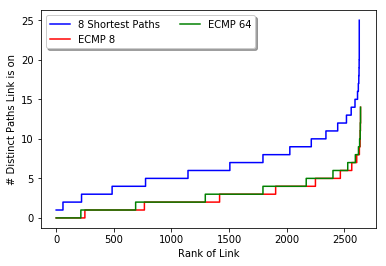

In [40]:
for i in lmap:
    lcount[lmap[i]] = 0

for i in range(S):
    run_bfs(server_map[i], server_map[permute_traffic[i]], 64)


sorted_lcount = sorted(lcount.items(), key=operator.itemgetter(1))
# for i in sorted_lcount:
#     print i[1], reverse_lmap[i[0]]

plot_x64 = []
plot_y64 = []

for i in range(len(sorted_lcount)):
    plot_x64.append(i+1)
    plot_y64.append(sorted_lcount[i][1])

plt.plot(x, y, ls='solid', drawstyle='steps-post', label='8 Shortest Paths', color='blue')
plt.plot(plot_x8, plot_y8, ls='solid', drawstyle='steps-post', label='ECMP 8', color='red')
plt.plot(plot_x64, plot_y64, ls='solid', drawstyle='steps-post', label='ECMP 64', color='green')
plt.legend(loc='upper left', ncol=2, mode="shrink", shadow=True, fancybox=True)
plt.xlabel('Rank of Link')
plt.ylabel('# Distinct Paths Link is on')
plt.savefig('fig%d.png'%(N,), bbox_inches='tight')
plt.show()